In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
extracted_features =  pd.read_csv("/content/drive/MyDrive/TFM_Javier_Eneritz/DATOS_TFM/features_raw_total.csv")

In [ ]:
y_fold = pd.read_csv("/content/drive/MyDrive/TFM_Javier_Eneritz/DATOS_TFM/labels_raw_total.csv")

In [ ]:
print(extracted_features)

      flux__variance_larger_than_standard_deviation  flux__has_duplicate_max  \
0                                               0.0                      0.0   
1                                               0.0                      0.0   
2                                               0.0                      0.0   
3                                               0.0                      0.0   
4                                               0.0                      0.0   
...                                             ...                      ...   
7377                                            0.0                      0.0   
7378                                            0.0                      0.0   
7379                                            0.0                      0.0   
7380                                            0.0                      0.0   
7381                                            0.0                      0.0   

      flux__has_duplicate_min  flux__ha

In [ ]:
print(y_fold)

      Unnamed: 0      0
0              0   True
1              1   True
2              2  False
3              3   True
4              4   True
...          ...    ...
7377           3  False
7378           4  False
7379           5  False
7380           6  False
7381           7  False

[7382 rows x 2 columns]


In [ ]:
y_fold = y_fold.iloc[:, 1:]

In [ ]:
print(y_fold)

          0
0      True
1      True
2     False
3      True
4      True
...     ...
7377  False
7378  False
7379  False
7380  False
7381  False

[7382 rows x 1 columns]


In [ ]:
y_fold.value_counts()

,count
0,
False,4727
True,2655


Eliminar acarcteristicas ruidosas

In [ ]:
type(y_fold)

pandas.core.frame.DataFrame

In [ ]:
y = y_fold.squeeze()  # Convierte a Series si solo hay una columna

In [ ]:
type(y)

pandas.core.series.Series

In [ ]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
impute(extracted_features)
features_filtered = select_features(extracted_features, y) ##Elimina características irrelevantes o ruidosas que no ayudan al modelo a predecir correctamente.


/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['flux__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [ ]:
#print(features_filtered)

In [ ]:
y.value_counts()

,count
0,
False,4727
True,2655


Distribucion

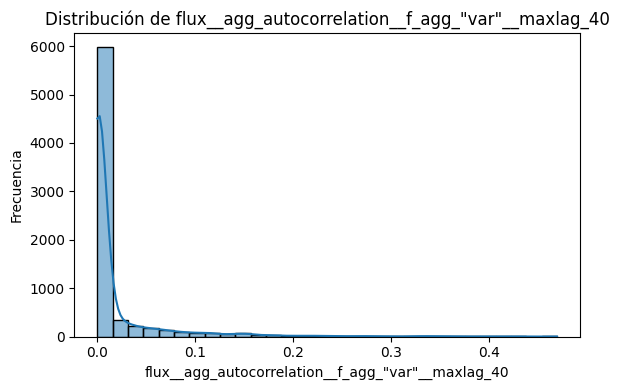

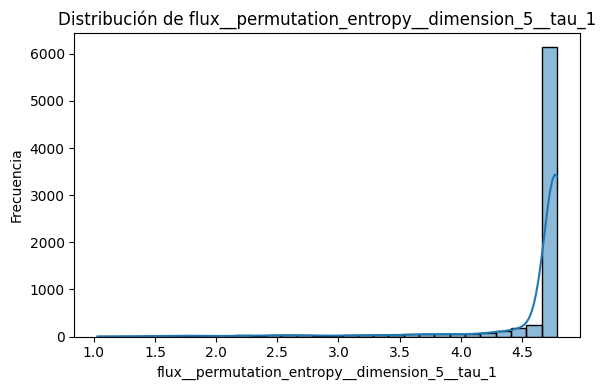

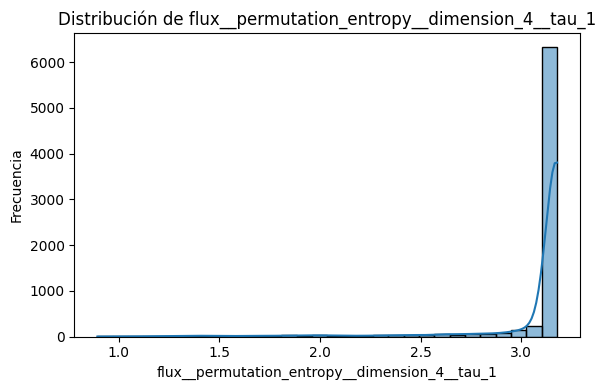

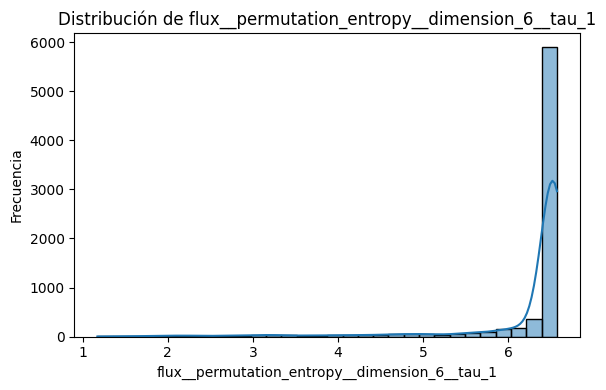

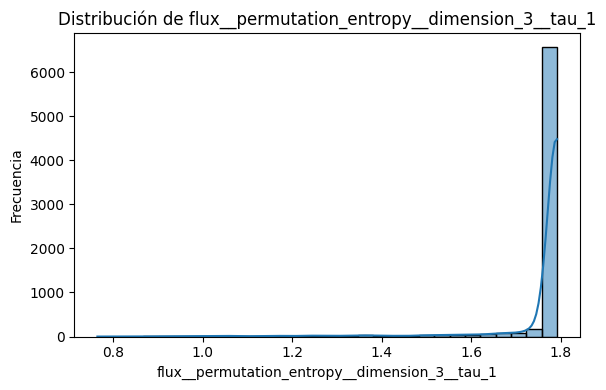

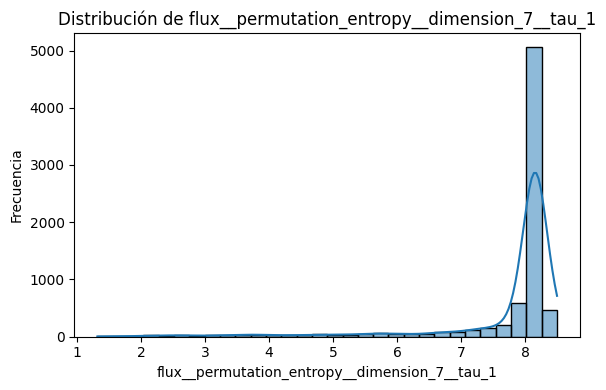

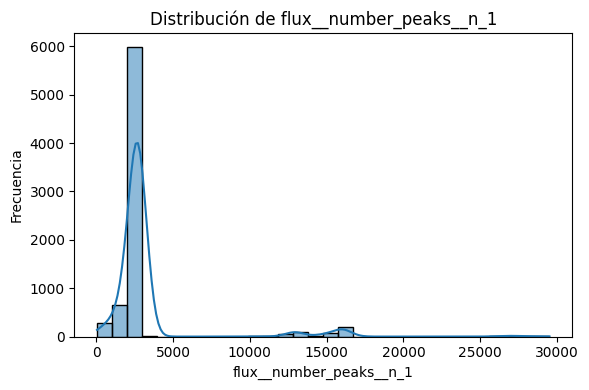

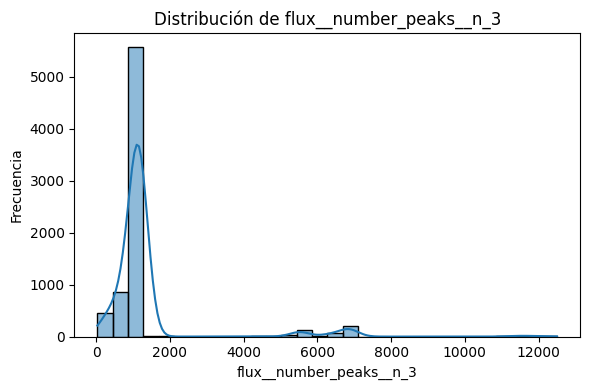

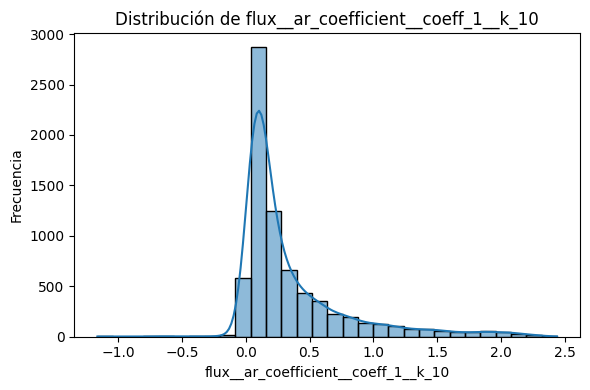

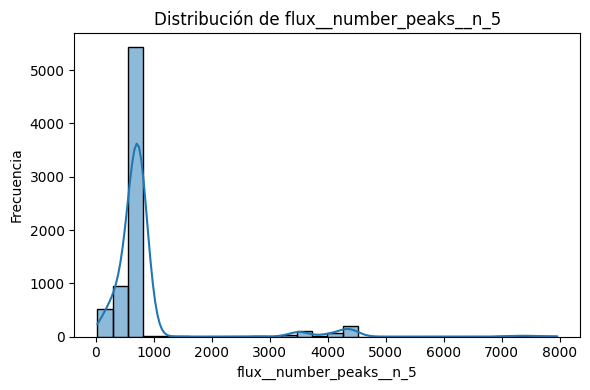

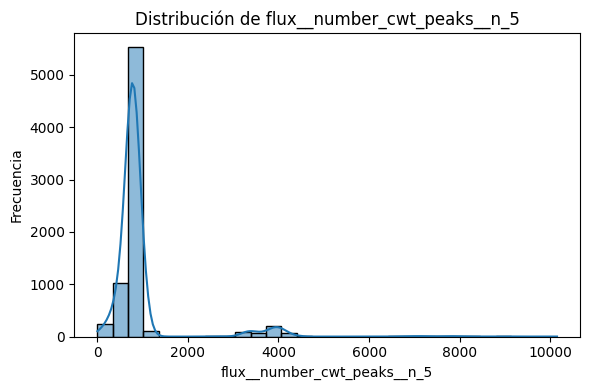

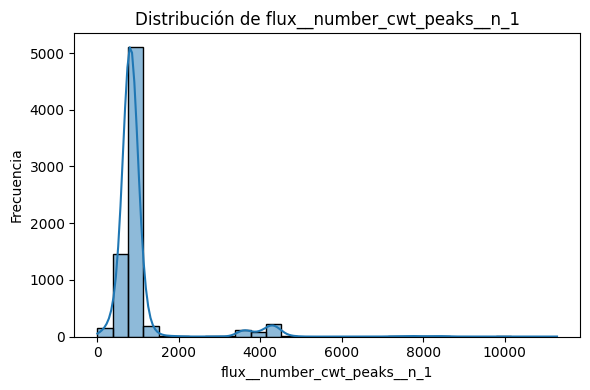

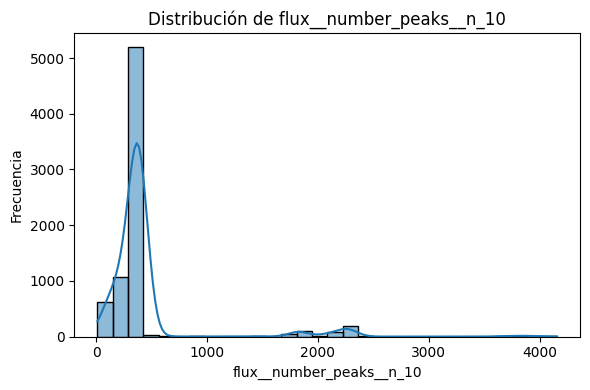

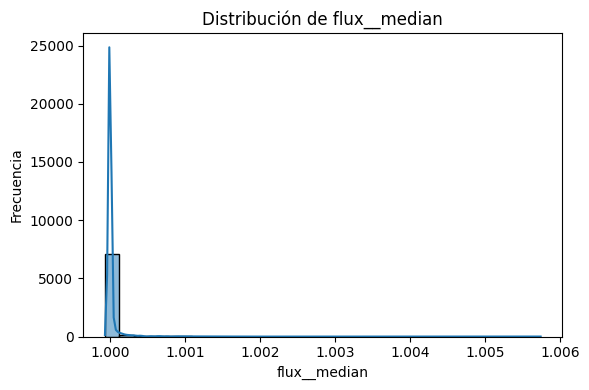

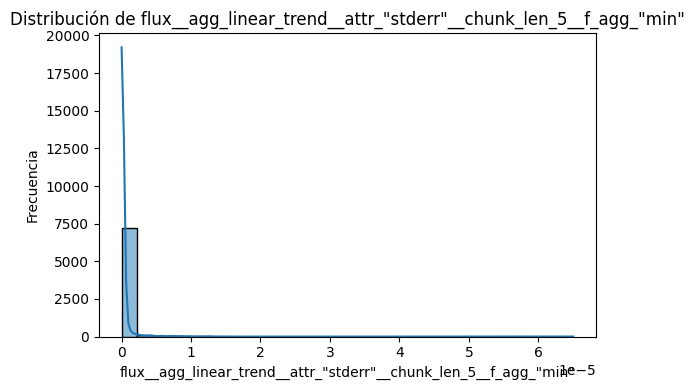

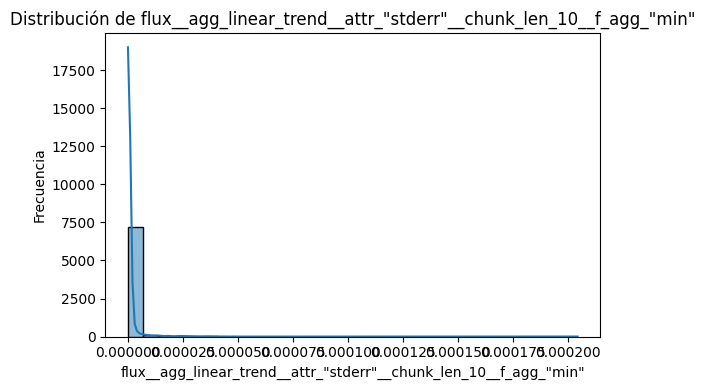

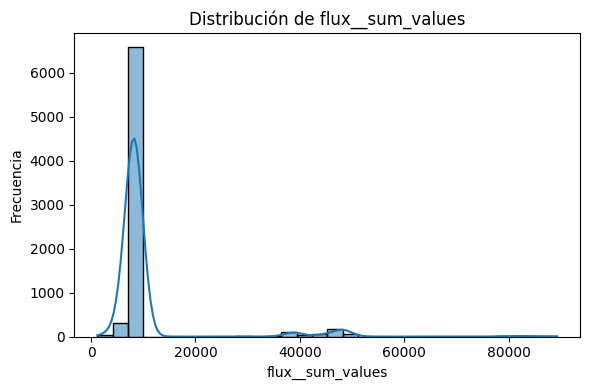

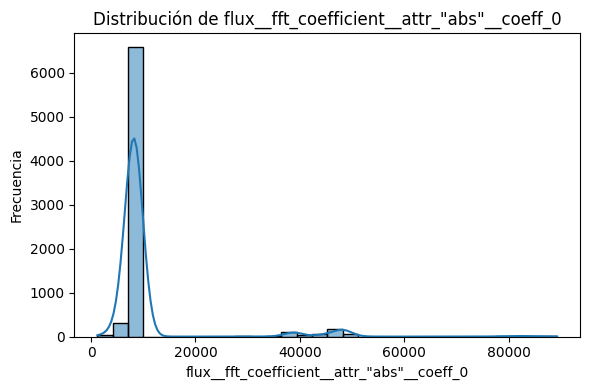

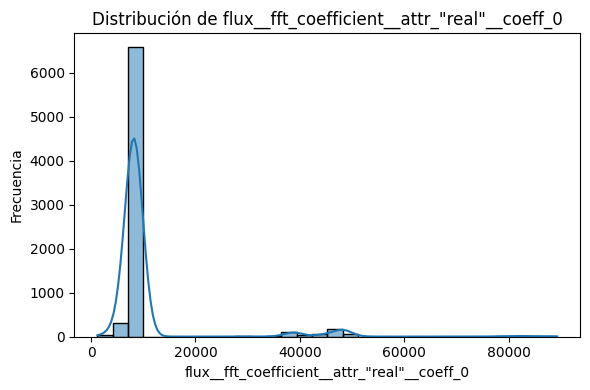

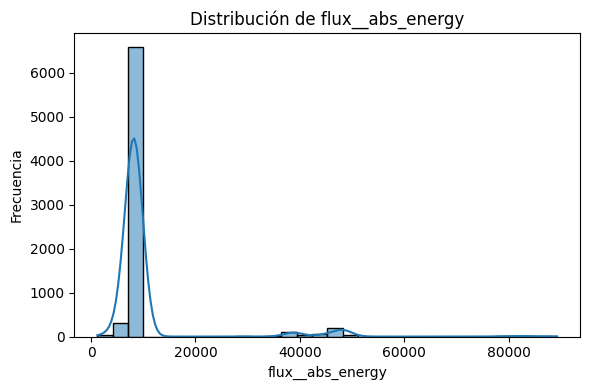

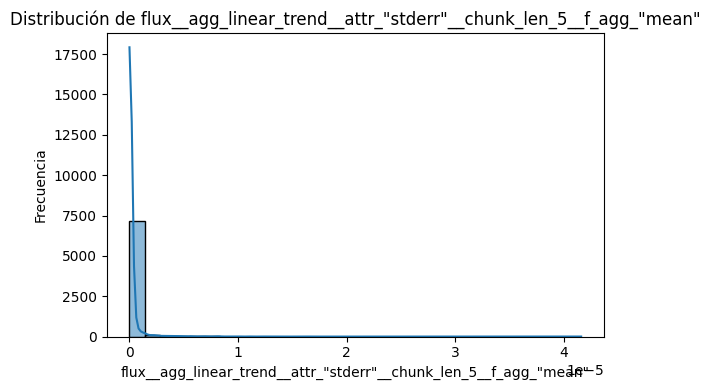

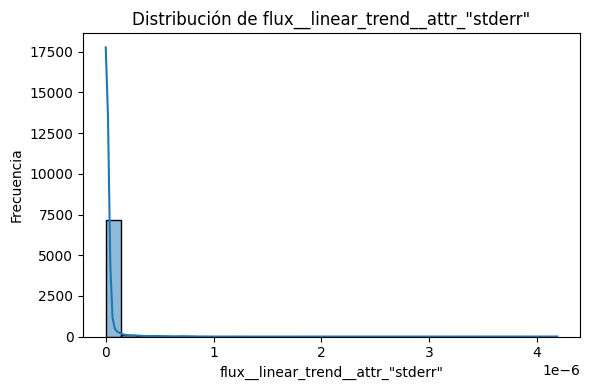

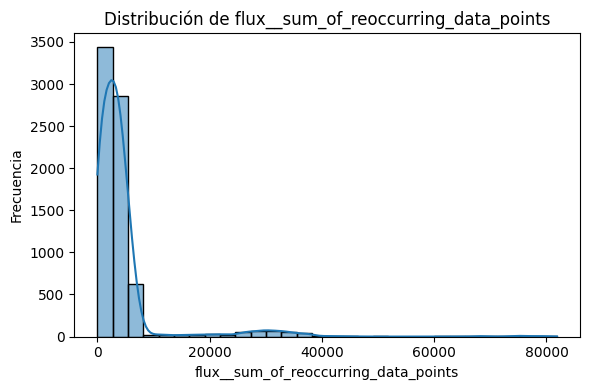

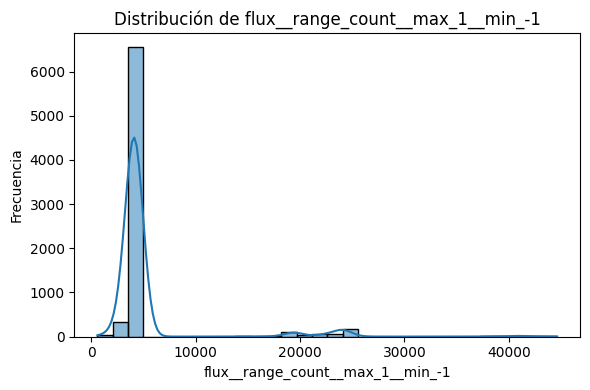

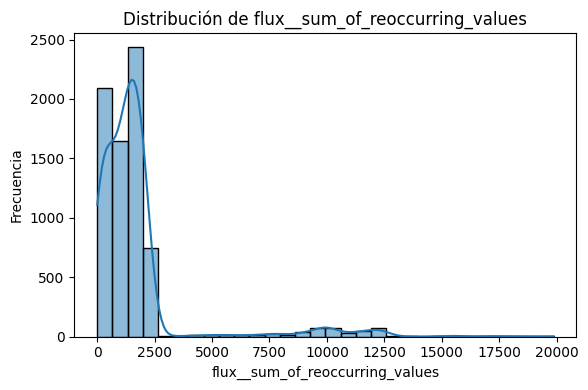

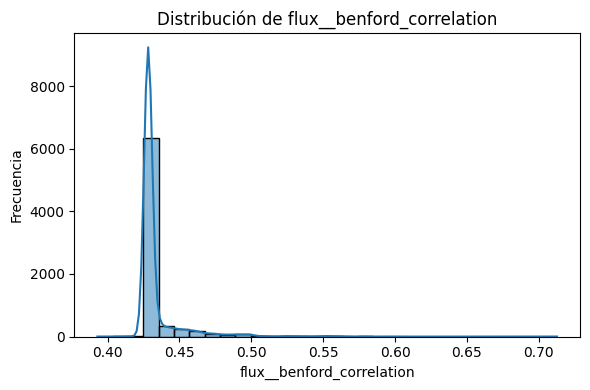

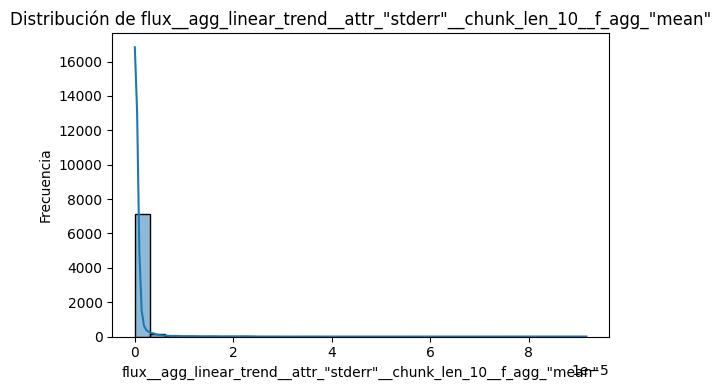

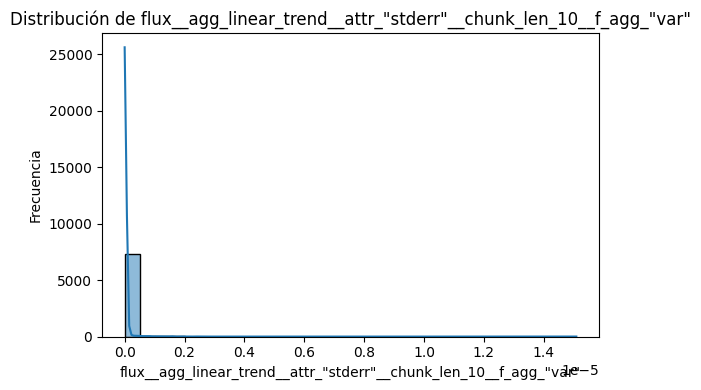

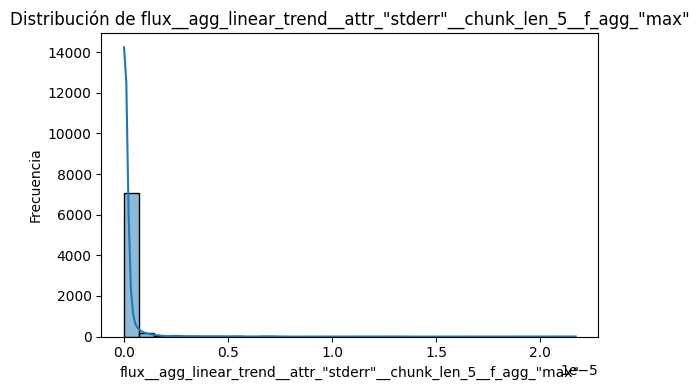

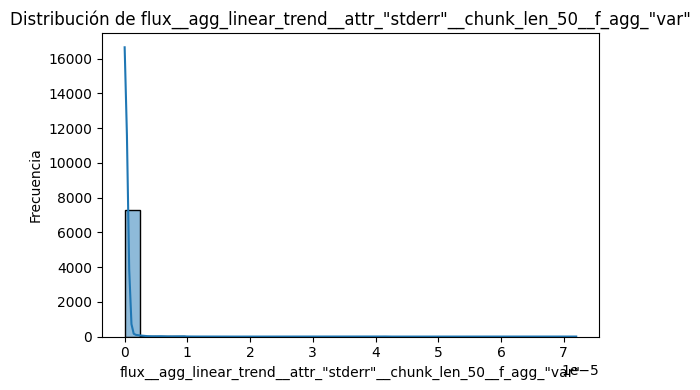

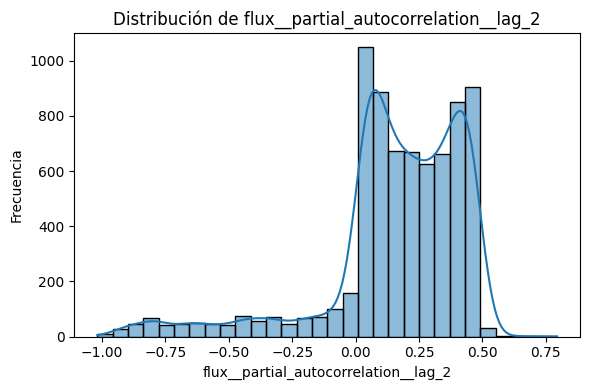

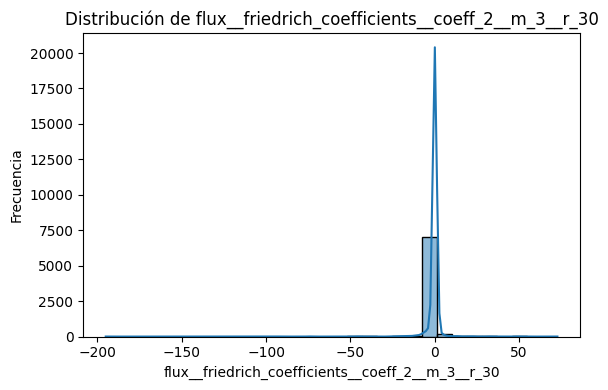

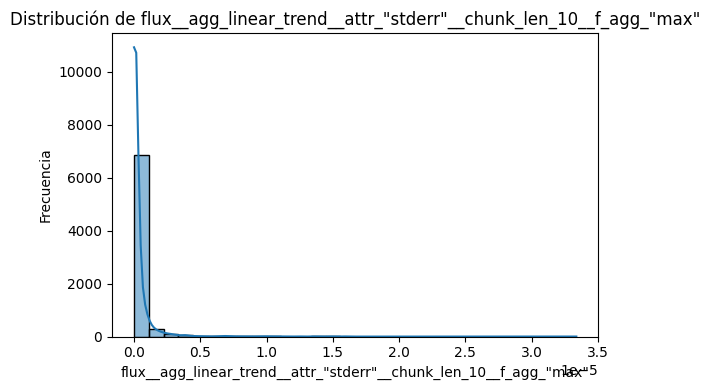

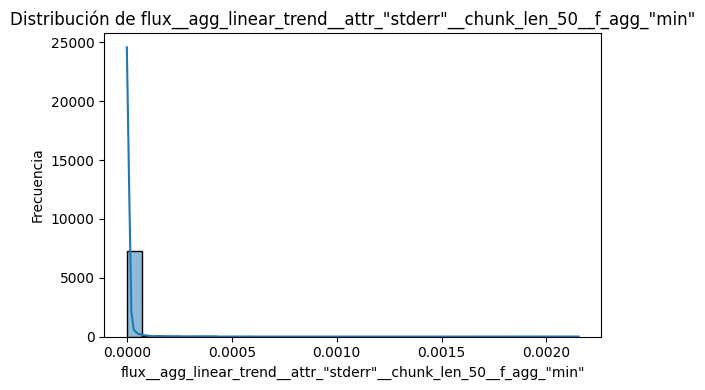

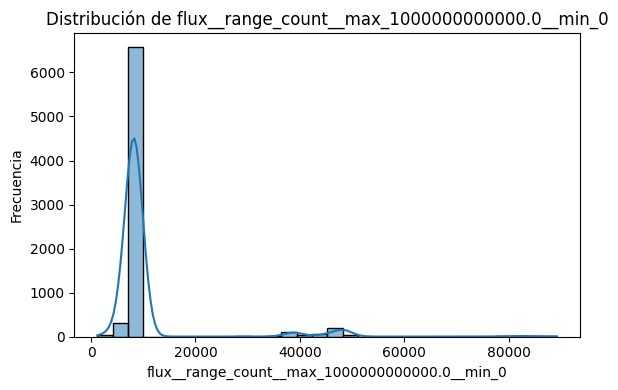

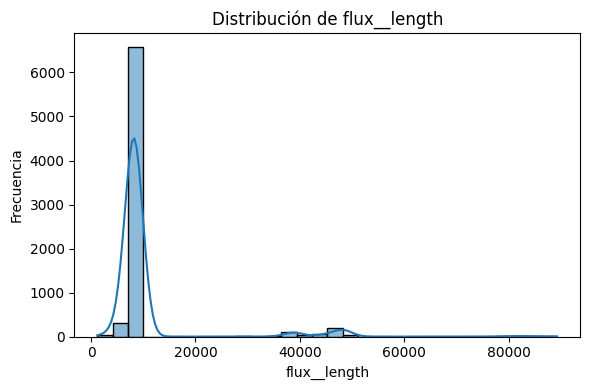

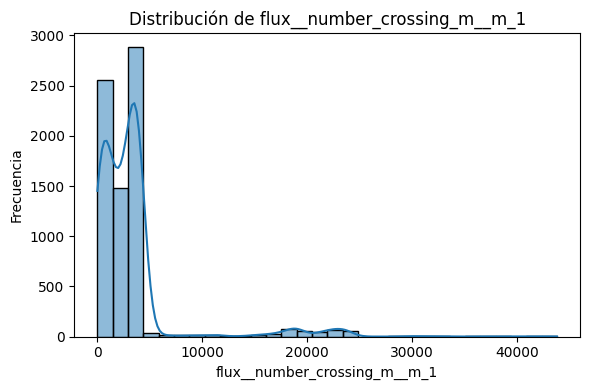

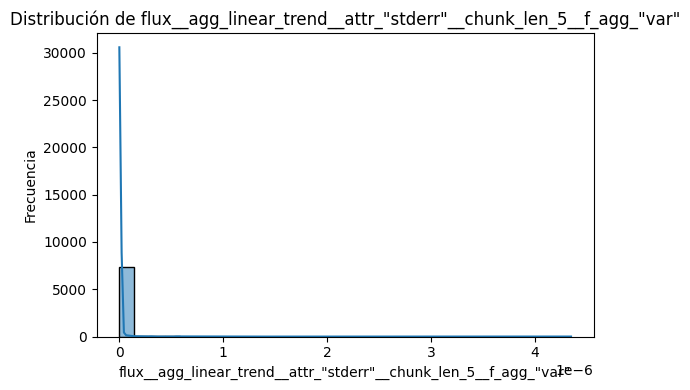

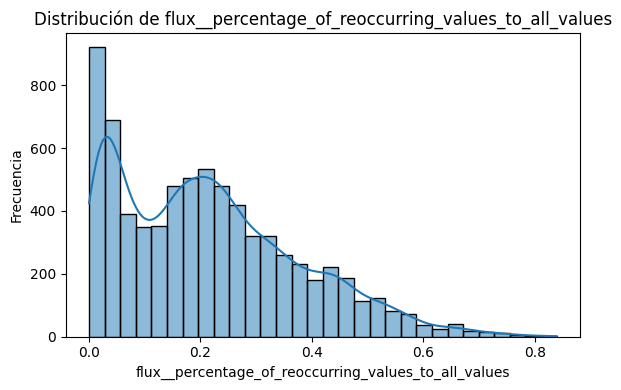

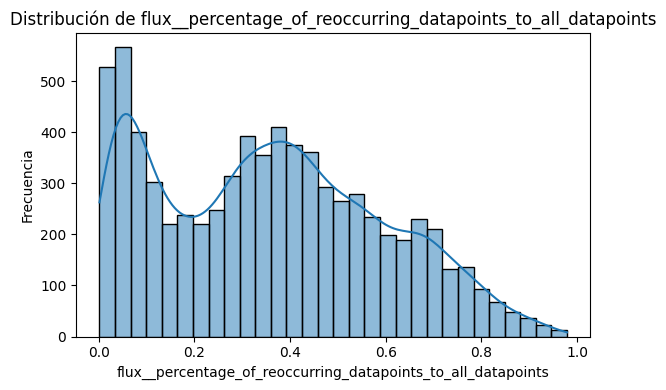

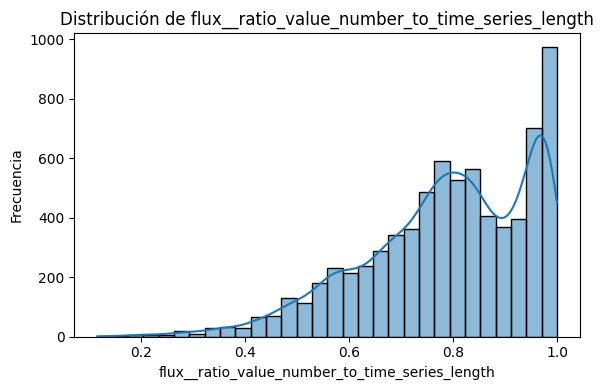

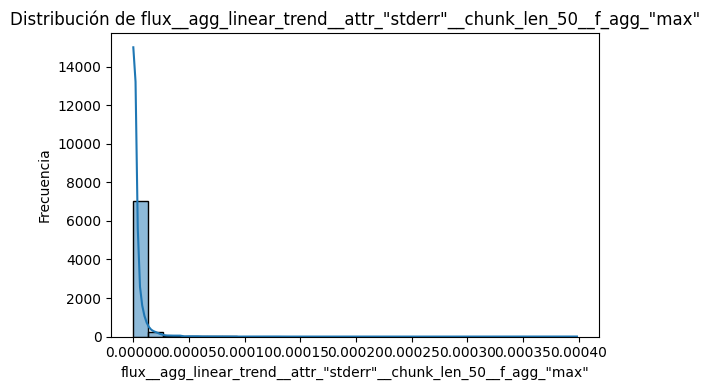

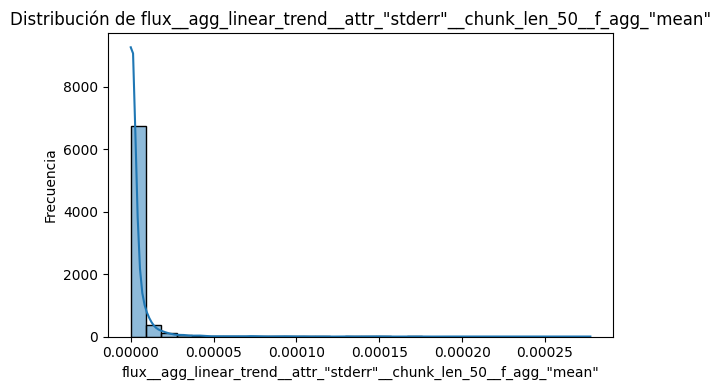

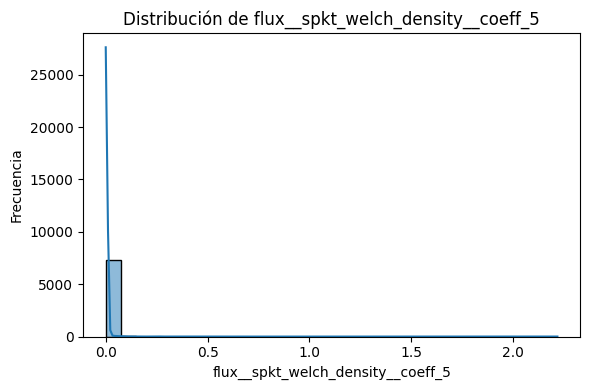

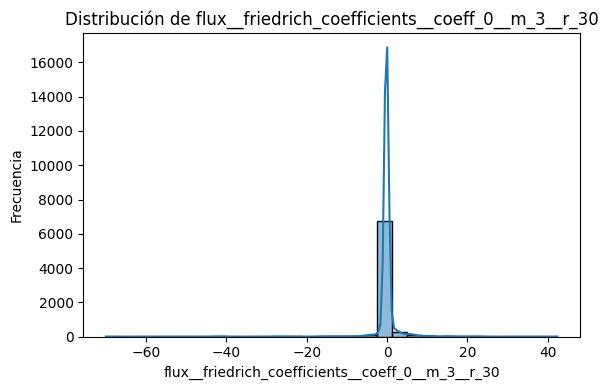

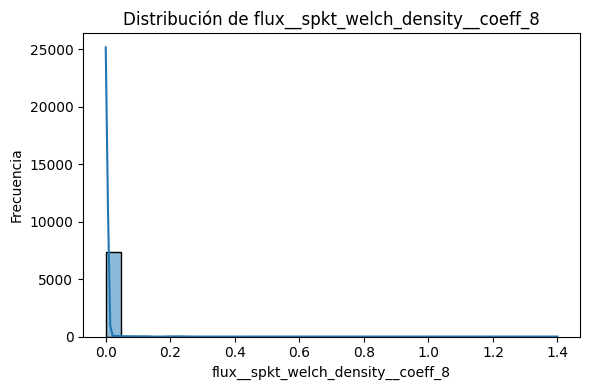

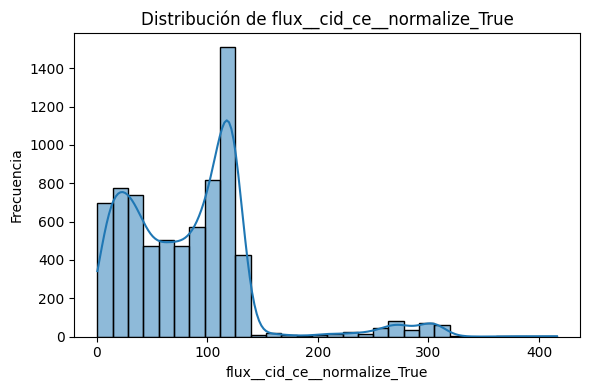

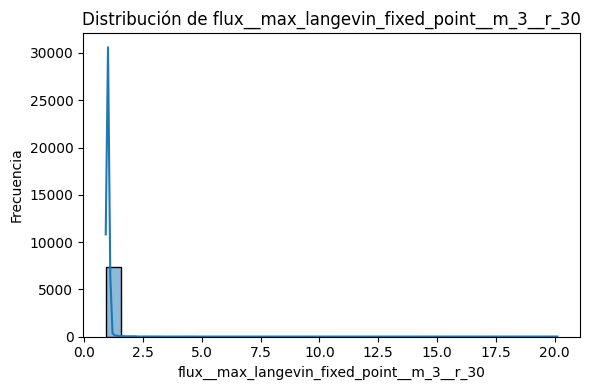

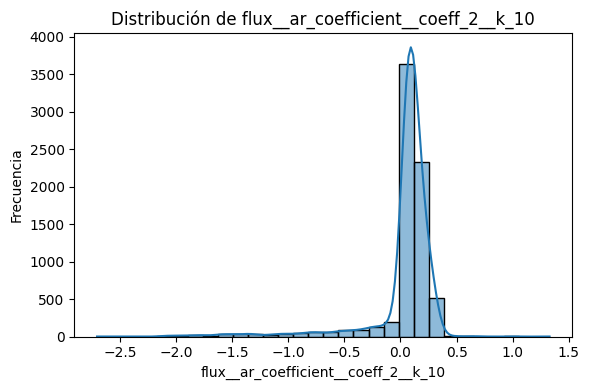

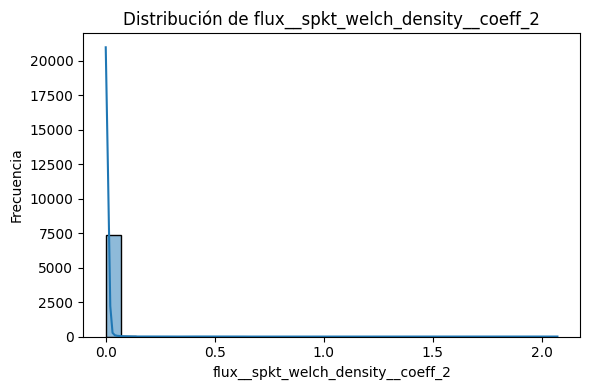

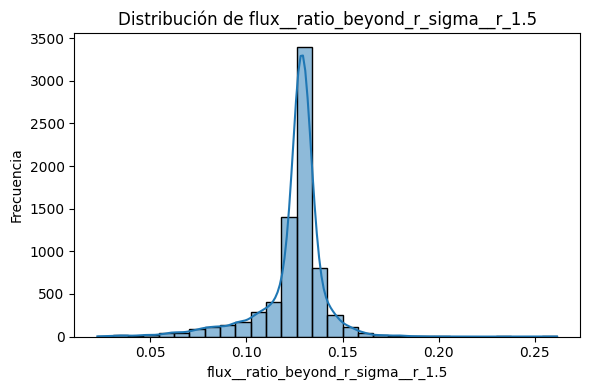

KeyboardInterrupt: 

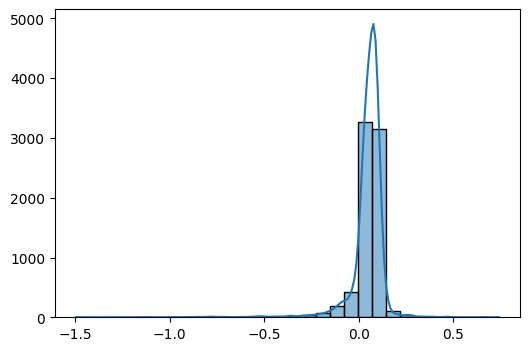

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Si features_filtered es un DataFrame
for col in features_filtered.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(features_filtered[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()


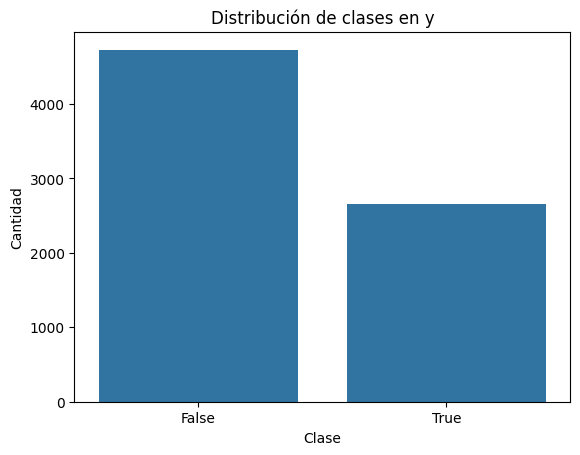

In [ ]:
sns.countplot(x=y)
plt.title('Distribución de clases en y')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()


Carcteristicas

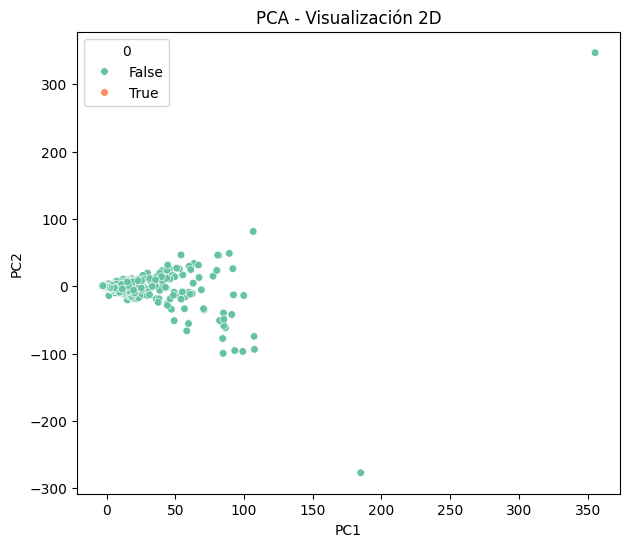

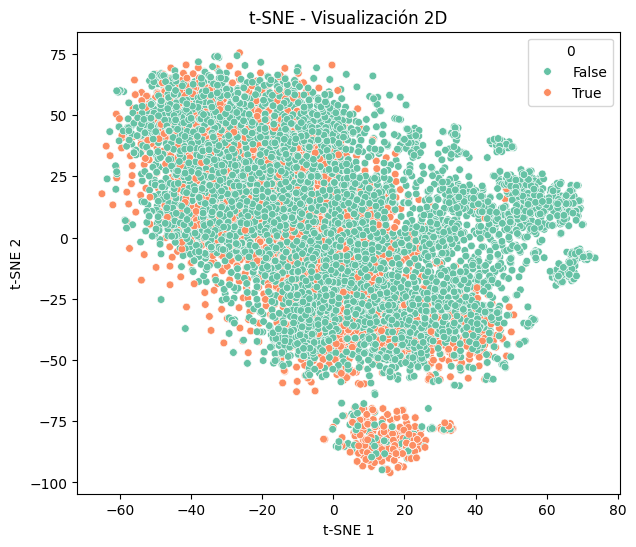

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


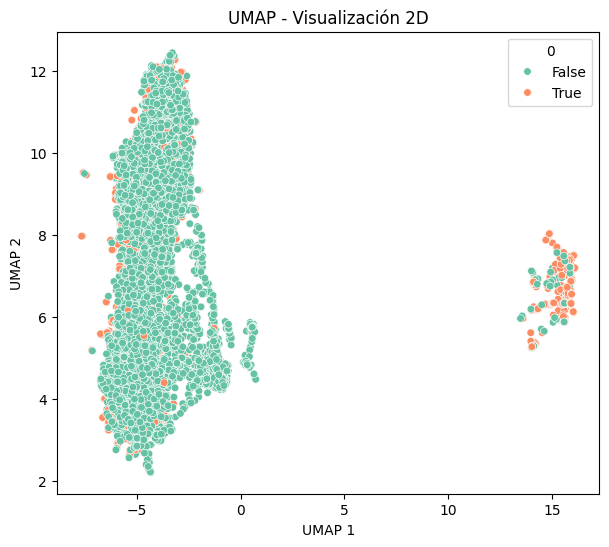

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

#Normalizacion
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(extracted_features)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(7, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2', s=30)
plt.title("PCA - Visualización 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(7, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2', s=30)
plt.title("t-SNE - Visualización 2D")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


# UMAP
try:
    import umap.umap_ as umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='Set2', s=30)
    plt.title("UMAP - Visualización 2D")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
except ImportError:
    print("UMAP no está instalado. Puedes instalarlo con: pip install umap-learn")

Few-shot

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class FewShotDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = features_filtered.values.astype(np.float32)
y_np = y.values

# Escalar
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Configuración Few-Shot
n_ways = 2        # clases por episodio
k_shots = 5       # ejemplos por clase para soporte
q_queries = 10    # ejemplos por clase para query

def create_episode(X, y, n_ways, k_shots, q_queries):
    available_classes = np.unique(y)
    if n_ways > len(available_classes):
        raise ValueError(f"n_ways={n_ways} es mayor que el número de clases disponibles ({len(available_classes)}).")

    classes = np.random.choice(available_classes, size=n_ways, replace=False)

    # ✅ Inicialización correcta
    support_x = []
    support_y = []
    query_x = []
    query_y = []

    for cls in classes:
        x_cls = X[y == cls]
        if len(x_cls) < (k_shots + q_queries):
            continue  # saltar clases con pocos ejemplos

        perm = np.random.permutation(len(x_cls))
        support = x_cls[perm[:k_shots]]
        query = x_cls[perm[k_shots:k_shots + q_queries]]

        support_x.append(support)
        query_x.append(query)
        support_y.extend([cls] * k_shots)
        query_y.extend([cls] * q_queries)

    # ⚠️ Verificar que se agregaron suficientes datos
    if len(support_x) == 0 or len(query_x) == 0:
        raise ValueError("No se pudieron generar suficientes ejemplos para el episodio. Prueba con k_shots y q_queries más bajos.")

    support_x = torch.tensor(np.concatenate(support_x), dtype=torch.float32)
    query_x = torch.tensor(np.concatenate(query_x), dtype=torch.float32)
    support_y = torch.tensor(support_y)
    query_y = torch.tensor(query_y)

    return support_x, support_y, query_x, query_y

# def create_episode_balanced(X, y, k_shots, q_queries):
#     # Forzar uso de las dos clases siempre
#     classes = np.array([0, 1])  # o [False, True] si y está en booleanos

#     support_x = []
#     support_y = []
#     query_x = []
#     query_y = []

#     for cls in classes:
#         x_cls = X[y == cls]
#         if len(x_cls) < (k_shots + q_queries):
#             raise ValueError(f"No hay suficientes ejemplos de la clase {cls}.")

#         perm = np.random.permutation(len(x_cls))
#         support = x_cls[perm[:k_shots]]
#         query = x_cls[perm[k_shots:k_shots + q_queries]]

#         support_x.append(support)
#         query_x.append(query)
#         support_y.extend([cls] * k_shots)
#         query_y.extend([cls] * q_queries)

#     support_x = torch.tensor(np.concatenate(support_x), dtype=torch.float32)
#     query_x = torch.tensor(np.concatenate(query_x), dtype=torch.float32)
#     support_y = torch.tensor(support_y)
#     query_y = torch.tensor(query_y)

#     return support_x, support_y, query_x, query_y



In [ ]:
print(y_np)

[ True  True False ... False False False]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingMLP(nn.Module):
    def __init__(self, input_dim=features_filtered.shape[1], embed_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
def prototypical_loss(model, support_x, support_y, query_x, query_y):
    model.eval()
    support_embed = model(support_x)
    query_embed = model(query_x)

    # Calcular centroides (prototipos) de cada clase
    prototypes = []
    for cls in torch.unique(support_y):
        cls_embed = support_embed[support_y == cls]
        prototypes.append(cls_embed.mean(dim=0))
    prototypes = torch.stack(prototypes)

    # Distancia euclídea al cuadrado
    dists = torch.cdist(query_embed, prototypes) ** 2
    log_p_y = F.log_softmax(-dists, dim=1)

    # Mapeo a clases (ordenadas como en torch.unique)
    query_labels = torch.tensor([torch.unique(support_y).tolist().index(lbl.item()) for lbl in query_y])
    loss = F.nll_loss(log_p_y, query_labels)
    acc = (log_p_y.argmax(dim=1) == query_labels).float().mean()
    return loss.item(), acc.item()


In [ ]:
model = EmbeddingMLP().to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for episode in range(300):
    support_x, support_y, query_x, query_y = create_episode(X, y_np, n_ways, k_shots, q_queries)
    # support_x, support_y, query_x, query_y = create_episode_balanced(X, y_np, k_shots, q_queries)
    support_x, support_y = support_x.to(model.net[0].weight.device), support_y.to(model.net[0].weight.device)
    query_x, query_y = query_x.to(model.net[0].weight.device), query_y.to(model.net[0].weight.device)

    model.train()
    optimizer.zero_grad()
    support_embed = model(support_x)
    query_embed = model(query_x)

    prototypes = []
    for cls in torch.unique(support_y):
        cls_embed = support_embed[support_y == cls]
        prototypes.append(cls_embed.mean(dim=0))
    prototypes = torch.stack(prototypes)

    dists = torch.cdist(query_embed, prototypes) ** 2
    log_p_y = F.log_softmax(-dists, dim=1)
    query_labels = torch.tensor([torch.unique(support_y).tolist().index(lbl.item()) for lbl in query_y]).to(log_p_y.device)

    loss = F.nll_loss(log_p_y, query_labels)
    acc = (log_p_y.argmax(dim=1) == query_labels).float().mean()

    loss.backward()
    optimizer.step()

    if episode % 20 == 0:
        print(f"Ep {episode}: Loss = {loss.item():.4f}, Acc = {acc.item():.4f}")

Ep 0: Loss = 0.7536, Acc = 0.4500
Ep 20: Loss = 2.1496, Acc = 0.6000
Ep 40: Loss = 0.6449, Acc = 0.6500
Ep 60: Loss = 0.7209, Acc = 0.3000
Ep 80: Loss = 0.6860, Acc = 0.5500
Ep 100: Loss = 0.5358, Acc = 0.9000
Ep 120: Loss = 0.6608, Acc = 0.6000
Ep 140: Loss = 0.7089, Acc = 0.5000
Ep 160: Loss = 1.0701, Acc = 0.5500
Ep 180: Loss = 0.5485, Acc = 0.7000
Ep 200: Loss = 0.6457, Acc = 0.6000
Ep 220: Loss = 0.6924, Acc = 0.6500
Ep 240: Loss = 0.5993, Acc = 0.6500
Ep 260: Loss = 0.6842, Acc = 0.5500
Ep 280: Loss = 0.5537, Acc = 0.7500


Evaluacion few-shot

In [ ]:
def evaluate_few_shot(model, X, y, n_ways=2, k_shots=5, q_queries=10, n_episodes=100):
    model.eval()
    accs = []

    for ep in range(n_episodes):
        try:
            support_x, support_y, query_x, query_y = create_episode(X, y, n_ways, k_shots, q_queries)
            device = next(model.parameters()).device
            support_x, query_x = support_x.to(device), query_x.to(device)

            # Embeddings
            support_embed = model(support_x)
            query_embed = model(query_x)

            # Prototipos por clase
            prototypes = []
            unique_labels = torch.unique(support_y)
            for cls in unique_labels:
                proto = support_embed[support_y == cls].mean(dim=0)
                prototypes.append(proto)
            prototypes = torch.stack(prototypes)

            # Distancias y predicción
            dists = torch.cdist(query_embed, prototypes) ** 2
            pred = torch.argmin(dists, dim=1)
            true = torch.tensor([torch.where(unique_labels == lbl)[0].item() for lbl in query_y])

            acc = (pred.cpu() == true).float().mean().item()
            accs.append(acc)

        except Exception as e:
            print(f"❌ Episodio {ep+1} fallido: {e}")
            continue

    accs = np.array(accs)
    print(f"\n✅ Evaluación en {len(accs)} episodios:")
    print(f"Accuracy promedio: {accs.mean():.4f}")
    print(f"Desviación estándar: {accs.std():.4f}")


In [ ]:
evaluate_few_shot(model, X, y_np, k_shots=5, q_queries=10, n_episodes=100)


✅ Evaluación en 100 episodios:
Accuracy promedio: 0.6220
Desviación estándar: 0.1117


In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Crear un solo episodio con muchas muestras
# support_x, support_y, query_x, query_y = create_episode(X, y_np, n_ways=2, k_shots=10, q_queries=20)

# all_x = torch.cat([support_x, query_x])
# all_y = torch.cat([support_y, query_y])

# embeddings = model(all_x.to(device)).detach().cpu().numpy()

# # Reducción de dimensión
# X_2d = TSNE(n_components=2).fit_transform(embeddings)
# plt.figure(figsize=(8,6))
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=all_y, cmap='tab10', alpha=0.7)
# plt.title("Embeddings de episodios (t-SNE)")
# plt.colorbar()
# plt.show()


=== Reporte por clase ===
              precision    recall  f1-score   support

           0     0.6496    0.5950    0.6211      1000
           1     0.6264    0.6790    0.6516      1000

    accuracy                         0.6370      2000
   macro avg     0.6380    0.6370    0.6364      2000
weighted avg     0.6380    0.6370    0.6364      2000



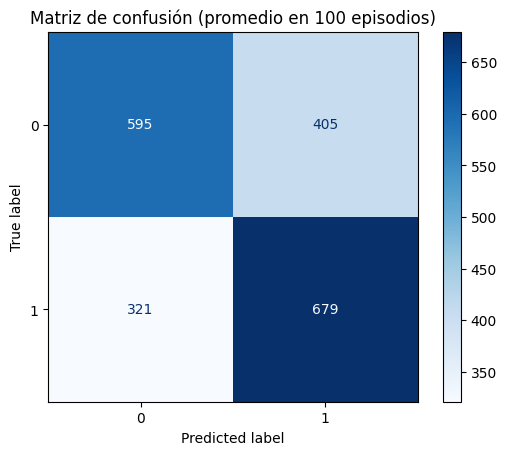

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Evaluación en múltiples episodios
all_preds = []
all_true = []

for _ in range(100):  # número de episodios
    support_x, support_y, query_x, query_y = create_episode(X, y_np, n_ways, k_shots, q_queries)

    support_x, support_y = support_x.to(model.net[0].weight.device), support_y.to(model.net[0].weight.device)
    query_x, query_y = query_x.to(model.net[0].weight.device), query_y.to(model.net[0].weight.device)

    with torch.no_grad():
        support_embed = model(support_x)
        query_embed = model(query_x)

        # Calcular prototipos
        prototypes = []
        unique_classes = torch.unique(support_y)
        for cls in unique_classes:
            cls_embed = support_embed[support_y == cls]
            prototypes.append(cls_embed.mean(dim=0))
        prototypes = torch.stack(prototypes)

        # Clasificación
        dists = torch.cdist(query_embed, prototypes) ** 2
        log_p_y = F.log_softmax(-dists, dim=1)
        preds = log_p_y.argmax(dim=1)

        # Mapear query_y al índice de clase local (0, 1, ..., n_ways-1)
        query_labels = torch.tensor([unique_classes.tolist().index(lbl.item()) for lbl in query_y]).to(preds.device)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(query_labels.cpu().numpy())

# ----- 🧮 Reporte de métricas -----
print("=== Reporte por clase ===")
print(classification_report(all_true, all_preds, digits=4))

# ----- 📊 Matriz de confusión -----
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión (promedio en 100 episodios)")
plt.show()

Contrastive Learning

In [ ]:
from torch.utils.data import Dataset, DataLoader

X = features_filtered.values.astype(np.float32)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_np = y.values

In [ ]:
class ContrastiveDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        return torch.tensor(self.augment(x), dtype=torch.float32), torch.tensor(self.augment(x), dtype=torch.float32)

    def augment(self, x):
        x_aug = x + 0.05 * np.random.randn(*x.shape)
        mask = np.random.binomial(1, 0.9, size=x.shape)
        return x_aug * mask

X_train, X_val, _, _ = train_test_split(X, y_np, test_size=0.2, random_state=42)
train_loader = DataLoader(ContrastiveDataset(X_train), batch_size=128, shuffle=True)

##########MODELO

class MLPEncoder(nn.Module):
    def __init__(self, input_dim, projection_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.projector = nn.Sequential(
            nn.Linear(128, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return F.normalize(z, dim=1)

model = MLPEncoder(input_dim=X.shape[1]).to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device

####CONTRASTIVE LOSS

def nt_xent_loss(z1, z2, temperature=0.5):
    batch_size = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)  # (2N, D)

    # Cosine similarity matrix
    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # (2N, 2N)

    # Mask to filter out self-similarity
    self_mask = torch.eye(2 * batch_size, device=z.device).bool()
    sim_matrix = sim_matrix.masked_fill(self_mask, -9e15)

    # Positive pairs: i-th in z1 with (i + N)-th in z2 and vice versa
    positives = torch.cat([torch.diag(sim_matrix, batch_size),
                           torch.diag(sim_matrix, -batch_size)], dim=0)

    # Labels (positives are at index 0)
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=z.device)

    # Compute logits
    logits = torch.cat([positives.unsqueeze(1), sim_matrix], dim=1)
    logits = logits / temperature

    loss = F.cross_entropy(logits, labels)
    return loss


####ENTRENAMIENTO

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x1, x2 in train_loader:
        x1, x2 = x1.to(device), x2.to(device)
        z1 = model(x1)
        z2 = model(x2)
        loss = nt_xent_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/20], Loss: 3.9929
Epoch [2/20], Loss: 3.7966
Epoch [3/20], Loss: 3.7588
Epoch [4/20], Loss: 3.7336
Epoch [5/20], Loss: 3.7257
Epoch [6/20], Loss: 3.7096
Epoch [7/20], Loss: 3.6989
Epoch [8/20], Loss: 3.6940
Epoch [9/20], Loss: 3.6885
Epoch [10/20], Loss: 3.6873
Epoch [11/20], Loss: 3.6811
Epoch [12/20], Loss: 3.6803
Epoch [13/20], Loss: 3.6833
Epoch [14/20], Loss: 3.6774
Epoch [15/20], Loss: 3.6739
Epoch [16/20], Loss: 3.6726
Epoch [17/20], Loss: 3.6694
Epoch [18/20], Loss: 3.6718
Epoch [19/20], Loss: 3.6695
Epoch [20/20], Loss: 3.6669


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 1. Usamos el encoder para extraer representaciones
model.eval()
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
with torch.no_grad():
    embeddings = model.encoder(X_tensor).cpu().numpy()

# 2. Dividir en train/test
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    embeddings, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# 3. Clasificador supervisado
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_enc, y_train_enc)
y_pred = clf.predict(X_test_enc)

# 4. Métricas
acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average='weighted')  # Puedes usar 'macro' o 'micro' también

print("Accuracy:", acc)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", confusion_matrix(y_test_enc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred))


Accuracy: 0.6939742721733243
F1 Score: 0.6705858954614708

Confusion Matrix:
 [[828 118]
 [334 197]]

Classification Report:
               precision    recall  f1-score   support

       False       0.71      0.88      0.79       946
        True       0.63      0.37      0.47       531

    accuracy                           0.69      1477
   macro avg       0.67      0.62      0.63      1477
weighted avg       0.68      0.69      0.67      1477



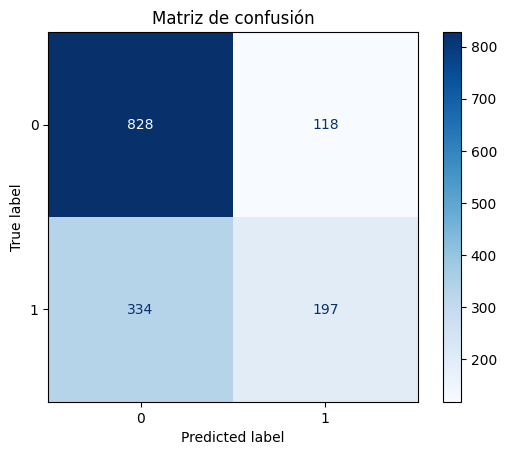

In [ ]:
# ----- 📊 Matriz de confusión -----
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()

Jerarquico

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

# ————————————— Carga y preparación de datos —————————————
# (parte de tu código previo)
# WIP: carga extracted_features_total y y como en mensajes anteriores
# …

impute(extracted_features)
features_filtered = select_features(extracted_features, y)
X = features_filtered.values.astype(np.float32)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
y_np = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y_np, test_size=0.2, random_state=42, stratify=y_np)

#Clustering jerárquico (pseudolabels)
n_clusters = 2
clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
pseudo_train = clusterer.fit_predict(X_train)
pseudo_test = clusterer.fit_predict(X_test)

#Combinación etiquetas reales y pseudolabels
# Usar solo una parte de etiquetas reales (ej: 20%) y pseudolabels para el resto
mask_labeled = np.random.rand(len(y_train)) < 0.3
y_train_semi = np.where(mask_labeled, y_train, pseudo_train)

###3Clasificador supervisado
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_semi)
y_pred = clf.predict(X_test)

#Evaluación final
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accurracy (semi):", acc)
print("F1 weighted (semi):", f1)
print("\nClassification Report (semi):\n", classification_report(y_test, y_pred))


Accurracy (semi): 0.6594448205822614
F1 weighted (semi): 0.5585980681872956

Classification Report (semi):
               precision    recall  f1-score   support

       False       0.66      0.98      0.79       946
        True       0.73      0.08      0.15       531

    accuracy                           0.66      1477
   macro avg       0.69      0.53      0.47      1477
weighted avg       0.68      0.66      0.56      1477



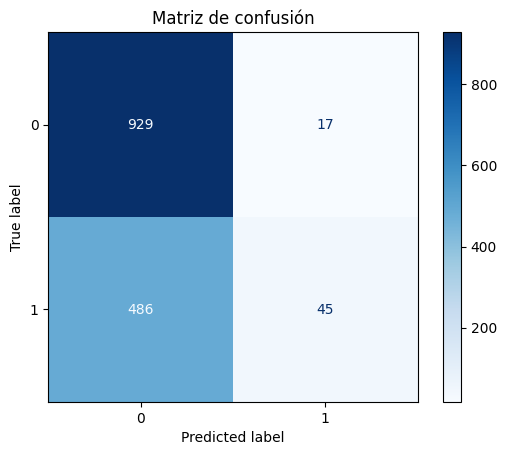

In [ ]:
# ----- 📊 Matriz de confusión -----
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()
